# Pulsar or Not Pulsar ?

In this notebook, you will use the HTRU2 Data Set which contains 17,898 samples of data
about radio frequency samples. You can find the database and its explanation on 
http://archive.ics.uci.edu/ml/datasets/HTRU2#
Pulsars are objects of interest for astrophysicists. However their detection is made difficult by
radio frequency interference and noise, and when a signal appears, most of the time it is due to human activity.
Supervised learning thus really saves time to researchers to filter unwanted signals. You will implement here a binary classification which will predict the nature (pulsar or noise) of a given signal. We will make predictions with Naive Bayes, which gives a probabilistic prediction for a signal to be a pulsar. For those who are curious, we will optionally explore the alternative Support Vector Machine (SVM) to see which model seems to be more convenient to solve our problem.

In [1]:
# First import Numpy, Pandas, and Matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# The file HTRU_2.csv contains the database which you will open with Pandas method read_csv
# By specifying header=None you tell Pandas that the database begins with the first line


file = 'HTRU_2.csv'
columns = ['MeanIP', 'StdIP', 'KurtosisIP', 'SkewnessIP', 
           'MeanCurve', 'StdCurve', 'KurtosisCurve', 'SkewnessCurve', 'Label']
Data = pd.read_csv(file, header=None)
Data.columns=columns

Let us have a look at the data! For more info about their meaning, you should read the web page quoted above.
You have 2 set of 4 labels (one for the 'integrated profile' and one for the 'curve') consisting of statistical characteristics of the given signals. You already know what are means and standard deviations. For kurtosis, let us say that it measures how far a curve looks from a Gaussian bell in shape, and for skewness, how asymmetric is the curve. You will have a clear idea about those concepts with the figures on this website: https://www.medcalc.org/manual/skewnesskurtosis.php

In [57]:
# Use the head() method to look at the first values. You can look further by specifying a number in the parenthesis
Data.head()

,MeanIP,StdIP,KurtosisIP,SkewnessIP,MeanCurve,StdCurve,KurtosisCurve,SkewnessCurve,Label
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
# We want to know the proportion of 0 and 1 labels. As you will see, we have much more noise than actual pulsars!
Data.Label.value_counts()

0    16259
1     1639
Name: Label, dtype: int64

Having a look at histograms allows seeing if there are similarities among features

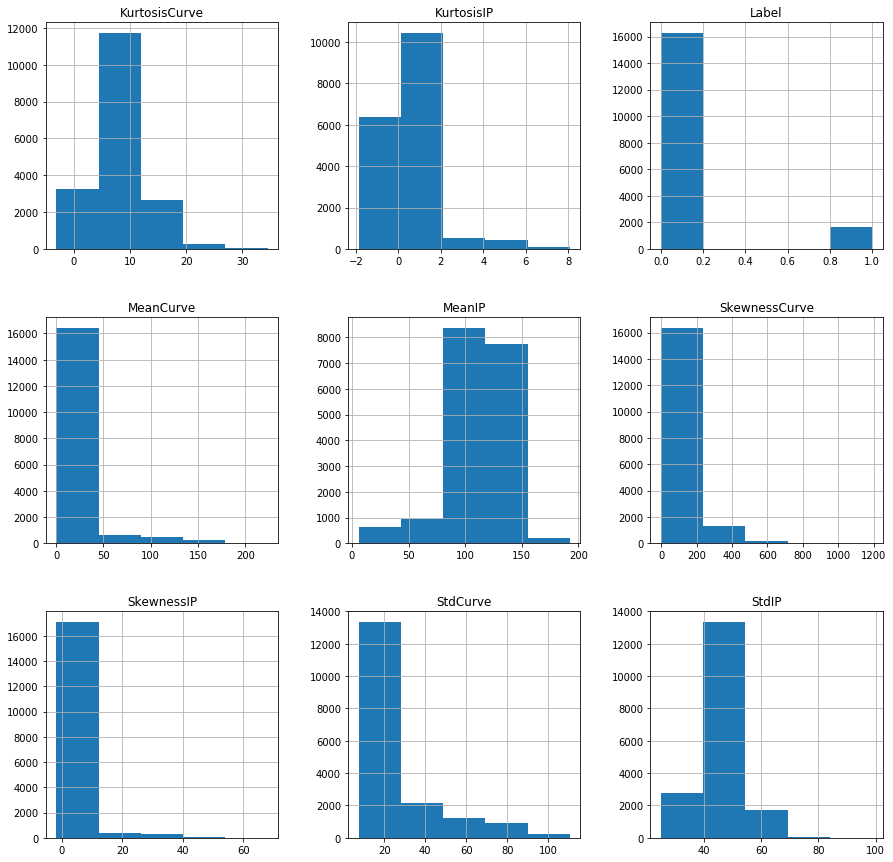

In [5]:
# Feel free to play with the bins here to change the width of the histograms

DataPlot = Data.hist(figsize=(15,15), bins=5)


You will learn much more information with 2-dimensional scatter plots. Here you can change the x,y,z values between 0 and 7 to plot one feature vs another. x and y correspond to the 2 axes, but you can also play with the z-coordinate which allows to chose one feature to scale the dot size.

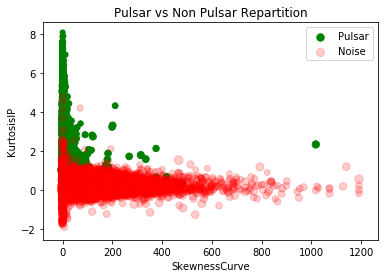

In [6]:
x = 7
y = 2
z = 1

plt.scatter(Data.iloc[:,x][Data.Label == 1],Data.iloc[:,y][Data.Label == 1], s=Data.iloc[:,z][Data.Label == 1],
            color='green', alpha=1., label='Pulsar')
plt.scatter(Data.iloc[:,x][Data.Label == 0],Data.iloc[:,y][Data.Label == 0], s=Data.iloc[:,z][Data.Label == 0],
            color='red', alpha=0.2, label='Noise')
plt.axes
plt.title('Pulsar vs Non Pulsar Repartition')
plt.xlabel(Data.columns[x])
plt.ylabel(Data.columns[y])
plt.legend()
plt.show()

As you see, both kurtosis features are good candidates to discriminate pulsars and non-pulsars! But there is still a zone where the separation is unclear. Now machine learning will help us to improve our naive idea!
We will take our features and labels from the database, and use them to train our model.

In [7]:
X = Data.iloc[:,0:8].values
Y = Data.Label.values

We will first apply the Gaussian Naive Bayes model to our data and measure its efficacity. To evaluate our model, the accuracy score may not be the best choice as you may prefer having more false positive to avoid missing some pulsar. So an appropriate metric could be an F beta-score. Here we choose a beta value of 2. Does it seem appropriate to you? You can have a look at the Wikipedia page about F beta scores in relation with precision and recall.

As you saw earlier there are much more 0 values than 1s. This can be an issue since in the region where 0 and 1 overlap in the scatter plot from above you are more interested in detecting ones than zeros. A solution is to give more weight to 1 values. For that, please have a look at the 'prior' argument in the GaussianNB documentation.

In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
clf = GaussianNB(priors=[0.1, 0.9])
clf.fit(X_train,y_train)
fbetascore = fbeta_score(clf.predict(X_test),y_test,beta=2.)
print('Score on the test set : {}'.format(str(fbetascore)))

Score on the test set : 0.5977382875605816


You may be interested to estimate the proportion of missed target. For that, we will test our model accuracy specifically on the subsets of ones. So you can then decide if your detection system is satisfying or not.

In [49]:
from sklearn.metrics import accuracy_score

acc_test = accuracy_score(clf.predict(X_test[y_test==1]), y_test[y_test==1])
acc_train = accuracy_score(clf.predict(X_train[y_train==1]), y_train[y_train==1])
print('The model detects {}% of the pulsars on the training set and {}% on the test set'.format(
        str(acc_train*100),str(acc_test*100)))

The model detects 87.61061946902655% of the pulsars on the training set and 87.05882352941177% on the test set


You may want to be alerted more frequently of the possibility for a signal to be a pulsar to miss less of them. A possibility with Naive Bayes is to exploit the probabilistic nature of the output and set a lower alert threshold to warn you when a signal has a high enough probability to be a pulsar. Here you can have a look at some values to see what are the chances for those to be a pulsar.

In [59]:
proba_out = clf.predict_proba(X)
# Have a look at the Data dataframe to find examples of pulsars and look at their predicted proba
yourValue = 19

print('The {}th signal has {} chances to be a pulsar'.format(str(yourValue), str(proba_out[yourValue,1])))


The 19th signal has 0.9999998538422332 chances to be a pulsar


In [77]:
proba_test = clf.predict_proba(X_test)
# Set the lowest probability for which you want to be warned of the possibility of a pulsar
threshold = 0.4

positive_test = proba_test[:,1] > threshold
accuracy_score(positive_test[y_test==1], y_test[y_test==1])


0.8823529411764706

As you see you detect more pulsars when you lower the threshold, but meanwhile you raise the number of false positive. Naive Bayes is very efficient for its simplicity. However there we may expect more accurate results with SVM. The separation that we saw earlier on the scatter plot is so clear that we may think that a good model should find a better decision boundary than the one that we found with Naive Bayes.

# Further material will be added later for SVM classification. Feel free to try by yourself!